In [1]:
import pandas as pd
import numpy as np
import sklearn as sl

In [2]:
ds = pd.read_csv('./data/train.csv', index_col='id')
ds.head(3)

,word,stress,num_syllables,lemma
id,,,,
0,румяной,2,3,румяный
1,цифрами,1,3,цифра
2,слугами,1,3,слуга


In [3]:
ds_ss = pd.read_csv('./data/sample_submission.csv')
ds_ss.head(3)

,id,stress
0,0,1
1,1,1
2,2,1


In [4]:
ds_ss.loc[ds_ss['stress'] != 1]

,id,stress


In [5]:
ds_test = pd.read_csv('./data/test.csv')
ds_test.head(3)

,id,word,num_syllables,lemma
0,0,эпилепсия,5,эпилепсия
1,1,относящейся,5,относиться
2,2,размышлениями,6,размышление


In [6]:
ds.describe()

,stress,num_syllables
count,63438.000000,63438.000000
mean,2.209354,3.489691
std,0.912874,1.158803
min,1.000000,1.000000
25%,2.000000,3.000000
50%,2.000000,3.000000
75%,3.000000,4.000000
max,6.000000,6.000000


# Поиск шумов

## Проверка на дурака: ударение на согласную букву не ставится!

In [7]:
ds_copy = ds.copy()

In [8]:
# «а» «у» «о» «и» «э» «ы» «я» «ю» «е» «ё»
vowels = ['а', 'е', 'ё', 'у', 'о', 'и', 'э', 'ы', 'ю', 'я']

#  Токенизация слов

In [9]:
ds[1000:1030]

,word,stress,num_syllables,lemma
id,,,,
1000,тренировками,3,5,тренировка
1001,профиле,1,3,профиль
1002,звала,2,2,звать
1003,окружающими,3,6,окружающий
1004,трансплантации,3,5,трансплантация
1005,смотрелся,2,3,смотреться
1006,радиочасы,5,5,радиочасы
1007,съемки,1,2,съемка
1008,платки,2,2,платок


* можно на выход подавать номер слога
* можно на выход подавать номер ударной буквы, тогда НС будет как бы бинарно классифицировать падает ли на эту букву ударение

# Посчитаем длину слов

In [10]:
ds['words_lenght'] = [len(word) for word in ds['word']]
ds.sample(5)

,word,stress,num_syllables,lemma,words_lenght
id,,,,,
22681,поливали,3,4,поливать,8
51376,кольчугино,1,4,кольчугино,10
5797,уточню,3,3,уточнять,6
49343,экстрасенсы,3,4,экстрасенс,11
50844,флаге,1,2,флаг,5


In [11]:
max_words_lenght = np.max(ds['words_lenght'])
max_words_lenght

20

In [12]:
ds['lemmas_lenght'] = [len(word) for word in ds['lemma']]
ds.sample(5)

,word,stress,num_syllables,lemma,words_lenght,lemmas_lenght
id,,,,,,
21857,атланте,2,3,атланта,7,7
18275,металась,2,3,метаться,8,8
25045,разминка,2,3,разминка,8,8
20891,закреплена,4,4,закреплять,10,10
55377,покинув,2,3,покидать,7,8


In [13]:
max_lemms_lenght = np.max(ds['lemmas_lenght'])
max_lemms_lenght

20

In [14]:
min_lemms_lenght = np.min(ds['lemmas_lenght'])
min_lemms_lenght

2

In [15]:
ds.loc[ds['lemmas_lenght'] <= 2]

,word,stress,num_syllables,lemma,words_lenght,lemmas_lenght
id,,,,,,
2994,уму,2,2,ум,3,2
4199,яру,1,2,яр,3,2
4738,ля,1,1,ля,2,2
6076,фе,1,1,фе,2,2
6191,ин,1,1,ин,2,2
...,...,...,...,...,...,...
59275,ша,1,1,ша,2,2
60673,мю,1,1,мю,2,2
61309,югу,1,2,юг,3,2


In [16]:
two_letter_words = ['еж', 'мы', 'уж', 'ус', 'яз', 'юг']

In [17]:
very_short_words = ds.loc[(ds['lemmas_lenght'] <= 2) & (~ds['lemma'].isin(two_letter_words))]

In [18]:
ds = ds.drop(index=very_short_words.index, axis=1)

In [19]:
bad_indexes = ds.loc[(ds['num_syllables'] == 1) & (~ds['lemma'].isin(two_letter_words))].index
ds = ds.drop(index=bad_indexes, axis=1)
len(bad_indexes)

1318

In [20]:
pd.set_option('display.max_rows', None)
three_letters_words = ds.loc[(ds['lemmas_lenght'] == 3) & (ds['words_lenght'] == 3)]
three_letters_words

,word,stress,num_syllables,lemma,words_lenght,lemmas_lenght
id,,,,,,
591,тыя,1,2,тыя,3,3
966,гаи,1,2,гаи,3,3
1047,эва,1,2,эва,3,3
1239,эла,1,2,эла,3,3
2054,ное,1,2,ной,3,3
2216,зою,1,2,зоя,3,3
2724,чао,1,2,чао,3,3
2875,тою,1,2,тот,3,3
3091,эры,1,2,эра,3,3


In [21]:
ds = ds.drop(index=three_letters_words.index, axis=1)

In [22]:
pd.set_option('display.max_rows', 5)

In [23]:
ds.loc[ds['num_syllables'] == 2]

,word,stress,num_syllables,lemma,words_lenght,lemmas_lenght
id,,,,,,
6,чёрта,1,2,черт,5,4
34,хроник,1,2,хроника,6,7
...,...,...,...,...,...,...
63428,рома,1,2,рома,4,4
63431,кулик,2,2,кулик,5,5


In [24]:
ds.sample(5)

,word,stress,num_syllables,lemma,words_lenght,lemmas_lenght
id,,,,,,
6272,сидящего,2,4,сидеть,8,6
10075,преподаю,4,4,преподавать,8,11
56509,сознанья,2,3,сознание,8,8
35776,завершилось,3,4,завершаться,11,11
45517,фарфоровой,2,4,фарфоровый,10,10


# Токенизируем слово и лемму

In [25]:
letter_list = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']
letter_by_number = {}
i = 1
for letter in letter_list:
    letter_by_number[letter] = i
    i+=1
letter_by_number

{'а': 1,
 'б': 2,
 'в': 3,
 'г': 4,
 'д': 5,
 'е': 6,
 'ё': 7,
 'ж': 8,
 'з': 9,
 'и': 10,
 'й': 11,
 'к': 12,
 'л': 13,
 'м': 14,
 'н': 15,
 'о': 16,
 'п': 17,
 'р': 18,
 'с': 19,
 'т': 20,
 'у': 21,
 'ф': 22,
 'х': 23,
 'ц': 24,
 'ч': 25,
 'ш': 26,
 'щ': 27,
 'ъ': 28,
 'ы': 29,
 'ь': 30,
 'э': 31,
 'ю': 32,
 'я': 33}

In [26]:
len(letter_by_number)

33

In [27]:
# Tokenize words
for i in range(0, max_words_lenght):
    ds[f'wl{i+1}'] = [(letter_by_number[word[i]] if len(word) > i else 0) for word in ds['word']]
    # is letter vowel?
    # ds[f'is_wl_v{i+1}'] = [(1 if (len(word) > i and word[i] in vowels) else 0) for word in ds['word']]
    # # How many vowels in the word?
    # i = 0
    # num_lemmas_syllables = 0
    # for id_ in ds['id']:
    #     word = ds.loc[ds['id'] == id_]['word']
    #     for letter in word:
    #         if letter in vowels:
    #             num_lemmas_syllables += 1
    #     ds.loc[ds['id'] == id_, 'num_lemmas_syllables'] = num_lemmas_syllables

In [28]:
# Tokenize lemms
for i in range(0, max_lemms_lenght):
    ds[f'll{i+1}'] = [(letter_by_number[lemma[i]] if len(lemma) > i else 0) for lemma in ds['lemma']]
    # is letter vowel?
    # ds[f'is_ll_v{i+1}'] = [(1 if (len(lemma) > i and lemma[i] in vowels) else 0) for lemma in ds['lemma']]

In [29]:
# pd.set_option('display.max_columns', None)
ds.sample(3)

,word,stress,num_syllables,lemma,words_lenght,lemmas_lenght,wl1,wl2,wl3,wl4,...,ll11,ll12,ll13,ll14,ll15,ll16,ll17,ll18,ll19,ll20
id,,,,,,,,,,,,,,,,,,,,,
24807,повешу,2,3,повесить,6,8,17,16,3,6,...,0,0,0,0,0,0,0,0,0,0
30523,маршрутом,2,3,маршрут,9,7,14,1,18,26,...,0,0,0,0,0,0,0,0,0,0
17765,пустует,2,3,пустовать,7,9,17,21,19,20,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# pd.set_option('display.max_columns', None)
ds.drop(['word', 'lemma'], axis=1).corr()

,stress,num_syllables,words_lenght,lemmas_lenght,wl1,wl2,wl3,wl4,wl5,wl6,...,ll11,ll12,ll13,ll14,ll15,ll16,ll17,ll18,ll19,ll20
stress,1.000000,0.656427,0.577145,0.578832,0.028239,-0.071823,-0.007377,-0.077250,-0.000099,0.043283,...,0.324876,0.311341,0.259391,0.208829,0.153163,0.104831,0.064374,0.042585,0.024785,0.015199
num_syllables,0.656427,1.000000,0.830938,0.748123,0.011482,-0.039289,-0.023500,-0.067969,0.031057,0.122305,...,0.436176,0.408514,0.346135,0.261458,0.186495,0.126625,0.084334,0.055126,0.029919,0.017251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ll19,0.024785,0.029919,0.060647,0.058614,0.006197,-0.001938,-0.000393,0.006397,0.007677,-0.001614,...,0.030782,0.021162,0.038740,0.050525,0.054969,0.082197,0.190070,0.322476,1.000000,0.566811
ll20,0.015199,0.017251,0.035496,0.035402,0.004990,-0.000969,0.001297,0.009399,0.004730,0.000991,...,0.021599,0.009269,0.025386,0.037054,0.008568,0.017887,0.128427,0.236278,0.566811,1.000000


In [31]:
ds.drop(['word', 'lemma', 'words_lenght', 'lemmas_lenght'], axis=1).corr()['stress'].to_list()

[1.0,
 0.6564274789160506,
 0.02823862360735054,
 -0.0718227582371788,
 -0.00737699684962736,
 -0.07724964319959438,
 -9.91412008924467e-05,
 0.043282686579965916,
 0.174978879458847,
 0.2754660289205564,
 0.33889184029145636,
 0.362823581438721,
 0.3452403547419484,
 0.32128390174954763,
 0.27256531938641043,
 0.21514511143735407,
 0.1522719739656988,
 0.09723905086858724,
 0.05629659976997764,
 0.035636797674180584,
 0.025282876121637588,
 0.014853550213908008,
 0.02800792693796384,
 -0.07029622525129446,
 -0.007853809554551207,
 -0.05399523819529905,
 0.04516781857202063,
 0.06922104814666133,
 0.17879574244064586,
 0.28023034003711894,
 0.3282049676863062,
 0.3426580047903542,
 0.3248758826487442,
 0.3113411332806829,
 0.2593908261615367,
 0.20882933178136343,
 0.15316295580603892,
 0.10483072729126441,
 0.06437435975025135,
 0.042584521292507456,
 0.024785013964155143,
 0.015199120301473825]

In [32]:
# ds_ = ds.drop(['id', 'word', 'lemma', 'words_lenght', 'lemmas_lenght'], axis=1)
ds_ = ds.drop(['word', 'lemma'], axis=1)

In [33]:
from sklearn.utils import shuffle
ds_ = shuffle(ds_)

# Trying AI

In [34]:
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LeakyReLU, Conv1D, MaxPooling1D, Embedding, Flatten
import tensorflow as tf
from tensorflow.keras import Sequential
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [35]:
# X, y = df.values[:, :-1], df.values[:, -1]
X = ds_.drop(['stress', 'num_syllables', 'words_lenght', 'lemmas_lenght'], axis=1)
# y = ds_['stress']

In [36]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
y = pd.DataFrame(encoder.fit_transform(ds_[['stress']]). toarray ())

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=True)

In [38]:
pd.set_option('display.max_columns', None)
X_train

,wl1,wl2,wl3,wl4,wl5,wl6,wl7,wl8,wl9,wl10,wl11,wl12,wl13,wl14,wl15,wl16,wl17,wl18,wl19,wl20,ll1,ll2,ll3,ll4,ll5,ll6,ll7,ll8,ll9,ll10,ll11,ll12,ll13,ll14,ll15,ll16,ll17,ll18,ll19,ll20
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31880,3,29,4,16,5,15,29,11,0,0,0,0,0,0,0,0,0,0,0,0,3,29,4,16,5,15,29,11,0,0,0,0,0,0,0,0,0,0,0,0
51793,4,21,2,6,18,15,1,20,16,18,6,0,0,0,0,0,0,0,0,0,4,21,2,6,18,15,1,20,16,18,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34452,3,1,18,30,10,18,21,6,20,19,33,0,0,0,0,0,0,0,0,0,3,1,18,30,10,18,16,3,1,20,30,19,33,0,0,0,0,0,0,0
28903,19,10,14,21,13,33,20,16,18,29,0,0,0,0,0,0,0,0,0,0,19,10,14,21,13,33,20,16,18,0,0,0,0,0,0,0,0,0,0,0


In [39]:
y_train

,0,1,2,3,4,5
53850,1.0,0.0,0.0,0.0,0.0,0.0
46196,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1517,0.0,1.0,0.0,0.0,0.0,0.0
56248,0.0,0.0,1.0,0.0,0.0,0.0


In [40]:
n_futures = len(X.columns)
n_futures

40

In [41]:
# Create a model
model = Sequential()

# model.add(BatchNormalization())

# Add input layer
# model.add(Dense(83, activation='softmax', input_shape = (n_futures,) ))
# model.add(Dense(100, activation='relu', input_shape = (n_futures,) ))
model.add(Embedding(input_dim=33, output_dim=6))

model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))

model.add(Dropout(0.1))
# model.add(Dropout(0.25))

model.add(BatchNormalization())
# model.add(Conv1D(filters=20 , kernel_size=4, strides=1, padding='same', activation='relu'))
model.add(Conv1D(filters=20 , kernel_size=4, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(2))

# model.add(Dense(100, activation='relu', input_shape = (n_futures,) ))
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(100, activation='relu'))

# model.add(Conv1D(filters=20 , kernel_size=4, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(2))
# model.add(Dense(100, activation='relu'))

model.add(Dropout(0.2))

model.add(BatchNormalization())

model.add(Flatten())

# output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              # optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [42]:
# # Compile

# model.compile(loss='mse',              
#               # optimizer=Adam(learning_rate=0.2), 
#               # optimizer='adam',
#               optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
#               # metrics=['mae'])
#               metrics=['mse'])

print(model.summary()) # Выводим структуру сети
# Train NN
history=model.fit(X_train,
                  y_train,
                  batch_size=100,
                  epochs=50,
                  # Подавляем вывол протоколов обучения.
                  # verbose=0,
                  # Используем 20% обучающих данных для валидации.
                  # validation_split = 0.2)
                 )



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.5481 - loss: 1.0414
Epoch 2/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.6627 - loss: 0.7858
Epoch 3/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.6861 - loss: 0.7421
Epoch 4/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.6909 - loss: 0.7329
Epoch 5/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7019 - loss: 0.7068
Epoch 6/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.7002 - loss: 0.7142
Epoch 7/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7051 - loss: 0.7001
Epoch 8/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7079 - loss: 0.7019
Epoch 9/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.7114 - loss: 0.6913
Epoch 10/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7193 - loss: 0.6757
Epoch 11/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7188 - loss: 0.6741
Epoch 12/50
558/558 ━━━━━

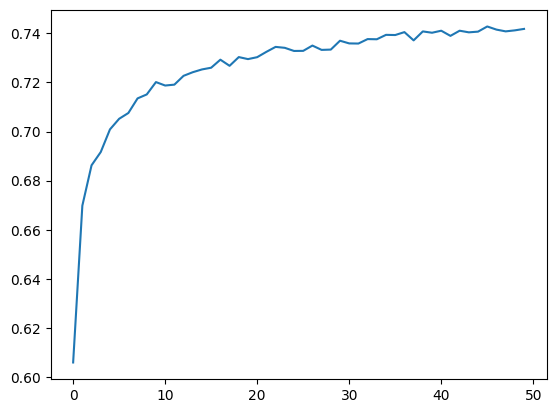

In [43]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['hindle'])
plt.show()

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


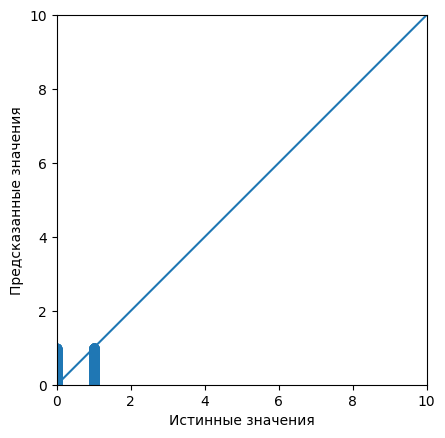

In [44]:
test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

In [45]:
from sklearn.metrics import roc_curve

In [46]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
# fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1], pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


ValueError: multilabel-indicator format is not supported

<Figure size 1000x800 with 0 Axes>